In [77]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

Load Data

In [78]:
tv = TvDatafeed()

df = tv.get_hist(symbol='SET:SET50', exchange='SET', interval=Interval.in_daily, n_bars=961)

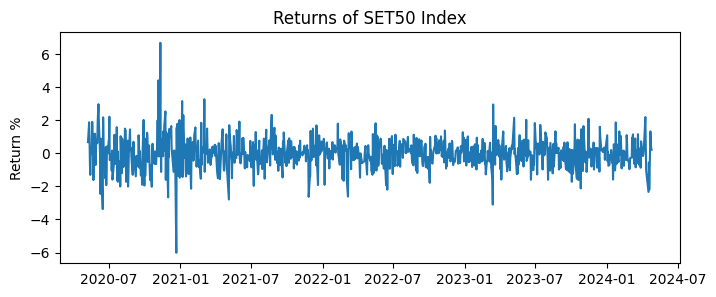

In [79]:
returns = np.log(df['close']).diff().dropna() * 100 #1st difference
plt.figure(figsize=(8,3))
plt.plot(returns)
plt.ylabel("Return %")
plt.title('Returns of SET50 Index');

Train-Test Split

In [80]:
returns_train, returns_test= returns[:-120], returns[-120:]

Methods tried

In [81]:
from arch import arch_model
garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off')
#print(garch_model_fit.summary)

In [82]:
arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off')
#print(arch_model_fit.summary)

In [83]:
gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off')
#print(gjr_garch_model_fit.summary)

In [84]:
harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off')
#print(harch_model_fit.summary)

Real Volatility

In [85]:
real_vol = []
for i in range(len(returns)):
    vol = returns[:i].std()
    real_vol.append(vol)
test_vol = real_vol[-120:]

Fixed-Window Forecast

In [86]:
garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)

In [87]:
garch = garch_forecast.variance.values[-1,:].flatten()
arch = arch_forecast.variance.values[-1,:].flatten()
gjr = gjr_garch_forecast.variance.values[-1,:].flatten()
harch = harch_forecast.variance.values[-1,:].flatten()

In [99]:
df_test = returns_test.to_frame(name='return')
df_test['garch']= np.sqrt(garch)
df_test['arch']= np.sqrt(arch)
df_test['gjr']= np.sqrt(gjr)
df_test['harch']= np.sqrt(harch)
df_test['Vol'] = np.array(test_vol)
df_test.head(10)

,return,garch,arch,gjr,harch,Vol
datetime,,,,,,
2023-10-30 09:00:00,0.755930,1.083692,1.049972,1.105026,1.049971,0.943956
2023-10-31 09:00:00,-1.074149,1.080718,0.962299,1.102295,0.962300,0.943751
2023-11-01 09:00:00,-0.172944,1.077797,0.946619,1.099605,0.946621,0.943921
2023-11-02 09:00:00,1.640181,1.074929,0.943933,1.096955,0.943935,0.943379
2023-11-03 09:00:00,1.091592,1.072112,0.943477,1.094346,0.943479,0.944505
2023-11-06 09:00:00,-0.272348,1.069346,0.943399,1.091776,0.943401,0.944687
2023-11-07 09:00:00,-0.549244,1.066629,0.943386,1.089246,0.943388,0.944176
2023-11-08 09:00:00,0.096337,1.063962,0.943384,1.086753,0.943386,0.943809
2023-11-09 09:00:00,-0.246759,1.061343,0.943384,1.084299,0.943386,0.943257


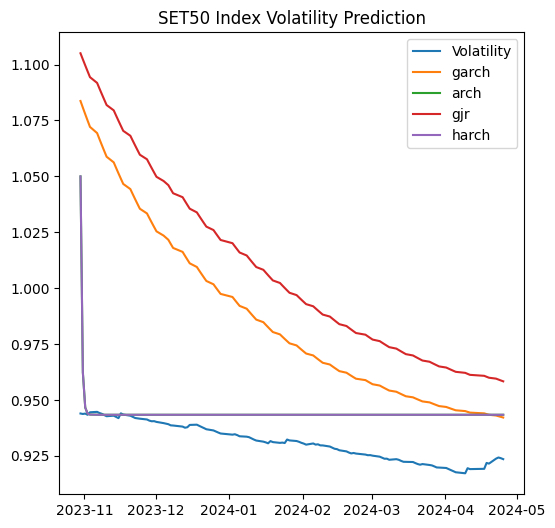

In [100]:
plt.figure(figsize=(6,6))
plt.plot(df_test['Vol'],label = 'Volatility')
plt.plot(df_test['garch'], label = 'garch') 
plt.plot(df_test['arch'], label = 'arch')
plt.plot(df_test['gjr'], label = 'gjr')
plt.plot(df_test['harch'], label = 'harch') 
plt.legend()
plt.title('SET50 Index Volatility Prediction')
plt.show()

Estimation Result

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

garch_mse = mean_squared_error(df_test['Vol'],df_test['garch'])
arch_mse = mean_squared_error(df_test['Vol'],df_test['arch'])
gjr_garch_mse = mean_squared_error(df_test['Vol'],df_test['gjr'])
harch_mse = mean_squared_error(df_test['Vol'],df_test['harch'])
mse = [garch_mse,arch_mse,gjr_garch_mse,harch_mse]

garch_rmse = np.sqrt(garch_mse)
arch_rmse = np.sqrt(arch_mse)
gjr_garch_rmse = np.sqrt(gjr_garch_mse)
harch_rmse = np.sqrt(harch_mse)
rmse = [garch_rmse,arch_rmse,gjr_garch_rmse,harch_rmse]

garch_mae = mean_absolute_error(df_test['Vol'],df_test['garch'])
arch_mae = mean_absolute_error(df_test['Vol'],df_test['arch'])
gjr_garch_mae = mean_absolute_error(df_test['Vol'],df_test['gjr'])
harch_mae = mean_absolute_error(df_test['Vol'],df_test['harch'])
mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]

garch_mape = mean_absolute_percentage_error(df_test['Vol'],df_test['garch'])
arch_mape = mean_absolute_percentage_error(df_test['Vol'],df_test['arch'])
gjr_garch_mape = mean_absolute_percentage_error(df_test['Vol'],df_test['gjr'])
harch_mape = mean_absolute_percentage_error(df_test['Vol'],df_test['harch'])
mape = [garch_mape,arch_mape,gjr_garch_mape,harch_mape]

In [102]:
model = ['GARCH','ARCH','GJR','HARCH']
conclu = pd.DataFrame(model, columns=['Model'])
conclu['MSE'] = mse
conclu['RMSE'] = rmse
conclu['MAE'] = mae
conclu['MAPE'] = mape
conclu

,Model,MSE,RMSE,MAE,MAPE
0,GARCH,0.004249,0.065181,0.056711,0.060622
1,ARCH,0.000310,0.017594,0.013269,0.014309
2,GJR,0.007266,0.085240,0.078209,0.083688
3,HARCH,0.000310,0.017595,0.013271,0.014311


Fit entire dataset with the best model

In [117]:
forecast_model_fit = arch_model(returns,vol="ARCH").fit(disp='off')
print(forecast_model_fit.summary)

<bound method ARCHModelResult.summary of                       Constant Mean - ARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1267.52
Distribution:                  Normal   AIC:                           2541.04
Method:            Maximum Likelihood   BIC:                           2555.64
                                        No. Observations:                  960
Date:                Thu, Apr 25 2024   Df Residuals:                      959
Time:                        14:26:01   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            

In [118]:
forecaste = forecast_model_fit.forecast(horizon=120,method='analytic',reindex=True)
y = forecaste.variance.values[-1,:].flatten()
df_y = pd.DataFrame(y)
df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(252)

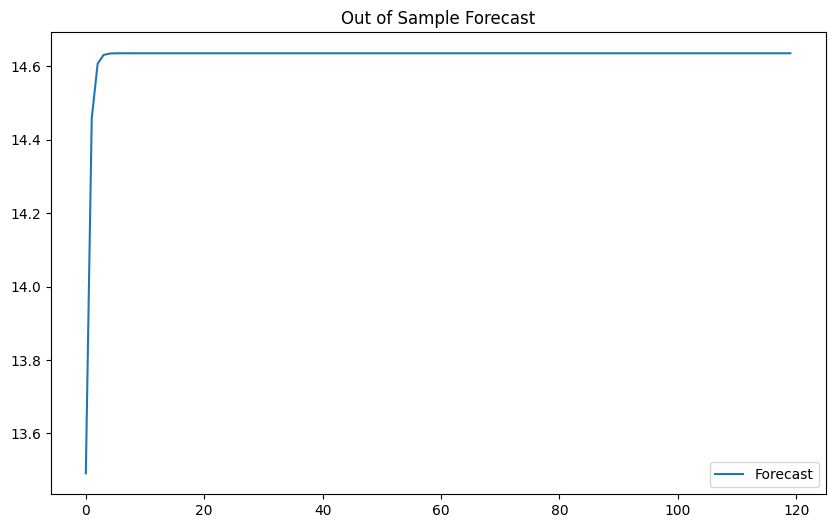

In [121]:
plt.figure(figsize=(10,6))
plt.plot(df_y['forecast'],label = 'Forecast')
plt.legend()
plt.title('Out of Sample Forecast')
plt.show()